In [29]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


class RewardModel(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", dropout_rate=0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(dropout_rate)
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        cls_emb = outputs.last_hidden_state[:, 0, :]  # CLS token
        cls_emb = self.dropout(cls_emb)
        reward = self.head(cls_emb).squeeze(-1)
        return reward


class PreferenceDataset(Dataset):
    def __init__(self, tokenizer, data, max_len=128):
        self.tokenizer = tokenizer
        self.data = data
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        prompt, winning, losing = item["prompt"], item["winning"], item["losing"]

        winning_enc = self.tokenizer(
            prompt + " [SEP] " + winning,
            truncation=True, 
            padding="max_length", 
            max_length=self.max_len, 
            return_tensors="pt"
        )
        losing_enc = self.tokenizer(
            prompt + " [SEP] " + losing,
            truncation=True, 
            padding="max_length", 
            max_length=self.max_len, 
            return_tensors="pt"
        )

        return {
            "winning_input_ids": winning_enc["input_ids"].squeeze(),
            "winning_mask": winning_enc["attention_mask"].squeeze(),
            "losing_input_ids": losing_enc["input_ids"].squeeze(),
            "losing_mask": losing_enc["attention_mask"].squeeze(),
        }


# Pairwise Loss Bradley–Terry: -log σ(s_winning - s_losing)
def preference_loss(winning_scores, losing_scores):

    return -torch.log(torch.sigmoid(winning_scores - losing_scores)).mean()


In [22]:
class EvaluationFramework:
    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.history = {
            'train_loss': [],
            'val_accuracy': [],
            'val_auc': [],
            'val_avg_margin': [],
            'val_consistency': []
        }

    def evaluate_on_pairs(self, test_data, batch_size=16):
        """Comprehensive evaluation on preference pairs"""
        self.model.eval()

        all_winning_scores = []
        all_losing_scores = []
        correct_predictions = 0
        total_samples = 0

        test_dataset = PreferenceDataset(self.tokenizer, test_data)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Evaluating"):
                winning_scores = self.model(
                    batch["winning_input_ids"].to(self.device),
                    batch["winning_mask"].to(self.device)
                )
                losing_scores = self.model(
                    batch["losing_input_ids"].to(self.device),
                    batch["losing_mask"].to(self.device)
                )

                all_winning_scores.extend(winning_scores.cpu().numpy())
                all_losing_scores.extend(losing_scores.cpu().numpy())

                # Count correct predictions
                correct_predictions += (winning_scores > losing_scores).sum().item()
                total_samples += len(winning_scores)

        all_winning_scores = np.array(all_winning_scores)
        all_losing_scores = np.array(all_losing_scores)

        accuracy = correct_predictions / total_samples
        y_true = np.ones(len(all_winning_scores))
        y_scores = all_winning_scores - all_losing_scores

        # Create binary labels for AUC
        auc_labels = np.concatenate([np.ones(len(all_winning_scores)),
                                     np.zeros(len(all_losing_scores))])
        auc_scores = np.concatenate([all_winning_scores, all_losing_scores])
        auc = roc_auc_score(auc_labels, auc_scores)

        # Average margin between winning and losing scores
        avg_margin = np.mean(all_winning_scores - all_losing_scores)

        # Consistency metric (% of times winning score > losing score by significant margin)
        significant_margin = 0.5
        consistency = np.mean((all_winning_scores - all_losing_scores) > significant_margin)

        metrics = {
            'accuracy': accuracy,
            'auc': auc,
            'avg_margin': avg_margin,
            'consistency': consistency,
            'n_samples': total_samples,
            'winning_scores_mean': np.mean(all_winning_scores),
            'losing_scores_mean': np.mean(all_losing_scores),
            'winning_scores_std': np.std(all_winning_scores),
            'losing_scores_std': np.std(all_losing_scores)
        }

        return metrics

    def evaluate_single_responses(self, prompts_and_responses):

        
        
        self.model.eval()
        results = []

        with torch.no_grad():
            for item in prompts_and_responses:
                prompt = item['prompt']
                response = item['response']
                enc = self.tokenizer(
                    prompt + " [SEP] " + response,
                    truncation=True,
                    padding="max_length",
                    max_length=128,
                    return_tensors="pt"
                )
                score = self.model(
                    enc["input_ids"].to(self.device),
                    enc["attention_mask"].to(self.device)
                ).item()

                results.append({
                    'prompt': prompt,
                    'response': response,
                    'reward_score': score
                })

        return results

    def plot_training_progress(self):

        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        # Training loss
        if self.history['train_loss']:
            axes[0, 0].plot(self.history['train_loss'])
            axes[0, 0].set_title('Training Loss')
            axes[0, 0].set_xlabel('Epoch')
            axes[0, 0].set_ylabel('Loss')
            axes[0, 0].grid(True)

        # Validation accuracy
        if self.history['val_accuracy']:
            axes[0, 1].plot(self.history['val_accuracy'], marker='o')
            axes[0, 1].set_title('Validation Accuracy')
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('Accuracy')
            axes[0, 1].grid(True)
        # Validation AUC
        if self.history['val_auc']:
            axes[1, 0].plot(self.history['val_auc'], marker='s', color='green')
            axes[1, 0].set_title('Validation AUC-ROC')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('AUC')
            axes[1, 0].grid(True)

        
        
        
        if self.history['val_avg_margin']:
            axes[1, 1].plot(self.history['val_avg_margin'], marker='^', color='orange')
            axes[1, 1].set_title('Average Score Margin (Winning - Losing)')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Margin')
            axes[1, 1].grid(True)

        plt.tight_layout()
        plt.show()

    def plot_score_distribution(self, test_data):
        self.model.eval()

        winning_scores = []
        losing_scores = []

        test_dataset = PreferenceDataset(self.tokenizer, test_data)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

        with torch.no_grad():
            for batch in test_loader:
                w_scores = self.model(
                    batch["winning_input_ids"].to(self.device),
                    batch["winning_mask"].to(self.device)
                )
                l_scores = self.model(
                    batch["losing_input_ids"].to(self.device),
                    batch["losing_mask"].to(self.device)
                )

                winning_scores.extend(w_scores.cpu().numpy())
                losing_scores.extend(l_scores.cpu().numpy())

        plt.figure(figsize=(10, 6))
        plt.hist(winning_scores, bins=30, alpha=0.5, label='Winning Responses', color='green')
        plt.hist(losing_scores, bins=30, alpha=0.5, label='Losing Responses', color='red')
        plt.xlabel('Reward Score')
        plt.ylabel('Frequency')
        plt.title('Distribution of Reward Scores')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        return winning_scores, losing_scores

In [3]:
from datasets import load_dataset

ds = load_dataset("allenai/reward-bench")

README.md: 0.00B [00:00, ?B/s]

data/raw-00000-of-00001.parquet:   0%|          | 0.00/5.59M [00:00<?, ?B/s]

data/filtered-00000-of-00001.parquet:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Generating raw split:   0%|          | 0/5123 [00:00<?, ? examples/s]

Generating filtered split:   0%|          | 0/2985 [00:00<?, ? examples/s]

In [14]:
ds

DatasetDict({
    raw: Dataset({
        features: ['prompt', 'chosen', 'chosen_model', 'rejected', 'rejected_model', 'subset', 'id'],
        num_rows: 5123
    })
    filtered: Dataset({
        features: ['prompt', 'chosen', 'chosen_model', 'rejected', 'rejected_model', 'subset', 'id'],
        num_rows: 2985
    })
})

In [15]:
ds['raw'].features

{'prompt': Value(dtype='string', id=None),
 'chosen': Value(dtype='string', id=None),
 'chosen_model': Value(dtype='string', id=None),
 'rejected': Value(dtype='string', id=None),
 'rejected_model': Value(dtype='string', id=None),
 'subset': Value(dtype='string', id=None),
 'id': Value(dtype='int64', id=None)}

In [16]:
ds['raw']

Dataset({
    features: ['prompt', 'chosen', 'chosen_model', 'rejected', 'rejected_model', 'subset', 'id'],
    num_rows: 5123
})

In [17]:
data = [
    {"prompt": "Why did the website crash?",
     "winning": "Too many users logging in caused a memory overflow.",
     "losing": "Aliens disabled the server."},
    {"prompt": "Why did the train stop?",
     "winning": "Signal failure on the main line.",
     "losing": "Because the sun forgot to rise."}
]
data

[{'prompt': 'Why did the website crash?',
  'winning': 'Too many users logging in caused a memory overflow.',
  'losing': 'Aliens disabled the server.'},
 {'prompt': 'Why did the train stop?',
  'winning': 'Signal failure on the main line.',
  'losing': 'Because the sun forgot to rise.'}]

In [18]:
ds['raw']['chosen_model']

['GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Turbo',
 'GPT4-Tur

In [9]:
final_dataset = [{"prompt": raw['prompt'], "winning": raw['chosen'], "losing": raw['rejected']} for raw in ds['raw']]

In [10]:
test_dataset = [{"prompt": raw['prompt'], "winning": raw['chosen'], "losing": raw['rejected']} for raw in ds['filtered']]
test_dataset

[{'prompt': 'How do I detail a car?',
  'winning': "Detailing a car involves a thorough cleaning inside and out, as well as polishing and waxing to protect the vehicle's surfaces. Here's a step-by-step guide to detailing a car:\n\n**Exterior Detailing:**\n\n1. **Wash the Car:**\n   - Rinse the car with water to remove loose dirt.\n   - Use a car wash soap and microfiber wash mitt to clean the car from top to bottom.\n   - Clean the wheels and tires with a brush and a wheel cleaner.\n   - Rinse the car thoroughly to remove all soap.\n\n2. **Dry the Car:**\n   - Use a microfiber towel or a chamois to dry the car to prevent water spots.\n\n3. **Clay Bar Treatment:**\n   - Use a clay bar with a lubricant to remove embedded surface contaminants from the paint.\n\n4. **Polishing:**\n   - Apply car polish with a dual-action polisher or by hand to correct paint imperfections and create a smooth surface.\n\n5. **Waxing:**\n   - Apply a coat of wax or paint sealant to protect the paint and give 

In [19]:
test_dataset[:3]

[{'prompt': 'How do I detail a car?',
  'winning': "Detailing a car involves a thorough cleaning inside and out, as well as polishing and waxing to protect the vehicle's surfaces. Here's a step-by-step guide to detailing a car:\n\n**Exterior Detailing:**\n\n1. **Wash the Car:**\n   - Rinse the car with water to remove loose dirt.\n   - Use a car wash soap and microfiber wash mitt to clean the car from top to bottom.\n   - Clean the wheels and tires with a brush and a wheel cleaner.\n   - Rinse the car thoroughly to remove all soap.\n\n2. **Dry the Car:**\n   - Use a microfiber towel or a chamois to dry the car to prevent water spots.\n\n3. **Clay Bar Treatment:**\n   - Use a clay bar with a lubricant to remove embedded surface contaminants from the paint.\n\n4. **Polishing:**\n   - Apply car polish with a dual-action polisher or by hand to correct paint imperfections and create a smooth surface.\n\n5. **Waxing:**\n   - Apply a coat of wax or paint sealant to protect the paint and give 

In [12]:
final_dataset

[{'prompt': 'What are the names of some famous actors that started their careers on Broadway?',
  'winning': 'Several famous actors started their careers on Broadway before making it big in film and television. Here are a few notable examples:\n\n1. Sarah Jessica Parker - Before she was Carrie Bradshaw on "Sex and the City," Sarah Jessica Parker was a Broadway star, having appeared in productions like "Annie" as a child.\n\n2. Meryl Streep - Meryl Streep\'s early career included Broadway productions such as "Trelawny of the \'Wells\'" and "A Memory of Two Mondays / 27 Wagons Full of Cotton."\n\n3. Hugh Jackman - Hugh Jackman won a Tony Award for his role in "The Boy from Oz" and has been known for his stage work as well as his film career.\n\n4. Sutton Foster - Known for her television role in "Younger," Sutton Foster is also a Broadway legend with leading roles in shows like "Thoroughly Modern Millie" and "Anything Goes."\n\n5. Kristen Bell - Before she was the voice of Anna in "Froze

In [12]:
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
import torch
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RewardModel().to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# before_responses=[]
# for data in test_dataset[:100]:

#     prompt, winning, losing = [], [], []
#     prompt.append(data["prompt"])
#     winning.append(data["winning"])
#     losing.append(data["losing"])

#     prompt_tokens = tokenizer(prompt, padding=True, truncation=True, return_tensors="pt").to(device)
#     model_output = model(prompt_tokens["input_ids"], prompt_tokens["attention_mask"])

#     before_responses.append(tokenizer.decode())

In [23]:
# from sklearn.metrics import roc_auc_score, accuracy_score
# import numpy as np

# @torch.no_grad()
# def evaluate_on_pairs(model, dataset, tokenizer, device=None, batch_size=8):
#     """
#     Evaluates the reward model on a dataset of {'prompt', 'winning', 'losing'} pairs.
#     Returns {'auc', 'accuracy', 'n'}.
#     """
#     model.eval()
#     if device is None:
#         device = next(model.parameters()).device

#     y_true, y_score = [], []

#     loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

#     for batch in tqdm(loader, desc="Evaluating"):
#         # winning_texts = [b["winning"] for b in batch]
#         # losing_texts = [b["losing"] for b in batch]

#         # win_tokens = tokenizer(winning_texts, padding=True, truncation=True, return_tensors="pt").to(device)
#         # lose_tokens = tokenizer(losing_texts, padding=True, truncation=True, return_tensors="pt").to(device)

#         win_rewards = model(batch["winning_input_ids"], batch["winning_mask"]).detach().cpu().numpy()
#         lose_rewards = model(batch["losing_input_ids"], batch["losing_mask"]).detach().cpu().numpy()

#         probs_left = 1 / (1 + np.exp(-(win_rewards - lose_rewards)))  # Bradley–Terry model
#         y_score.extend(probs_left)
#         y_true.extend([1] * len(batch))  # since "winning" > "losing"

#     y_score = np.array(y_score)
#     y_true = np.array(y_true)

#     auc = roc_auc_score(y_true, y_score) if len(np.unique(y_true)) > 1 else np.nan
#     acc = accuracy_score(y_true, (y_score > 0.5).astype(int))

#     return {"auc": float(auc), "accuracy": float(acc), "n": len(y_true)}


# @torch.no_grad()
# def evaluate_policy_pairwise(model, prompts, outputs_before, outputs_after, tokenizer, device=None):
#     """
#     Evaluate two sets of policy outputs (before and after fine-tuning)
#     using the reward model as a proxy scorer.

#     Returns {'avg_before', 'avg_after', 'winrate_after', 'n'}
#     """
#     model.eval()
#     if device is None:
#         device = next(model.parameters()).device

#     rewards_before, rewards_after = [], []

#     for p, before_text, after_text in zip(prompts, outputs_before, outputs_after):
#         before_toks = tokenizer(before_text, return_tensors="pt", padding=True, truncation=True).to(device)
#         after_toks = tokenizer(after_text, return_tensors="pt", padding=True, truncation=True).to(device)

#         # optimizer.zero_grad()

#         r_before = model(before_toks["input_ids"], before_toks["attention_mask"]).item()
#         r_after = model(after_toks["input_ids"], after_toks["attention_mask"]).item()

#         rewards_before.append(r_before)
#         rewards_after.append(r_after)

#     rewards_before = np.array(rewards_before)
#     rewards_after = np.array(rewards_after)

#     winrate = float((rewards_after > rewards_before).mean())
#     return {
#         "avg_before": float(rewards_before.mean()),
#         "avg_after": float(rewards_after.mean()),
#         "winrate_after": winrate,
#         "n": len(prompts)
#     }

In [24]:
# # from src.reward_model import RewardModel, PreferenceDataset, preference_loss
# from torch.utils.data import DataLoader
# from tqdm import tqdm

# # # Example synthetic dataset
# # data = [
# #     {"prompt": "Why did the website crash?",
# #      "winning": "Too many users logging in caused a memory overflow.",
# #      "losing": "Aliens disabled the server."},
# #     {"prompt": "Why did the train stop?",
# #      "winning": "Signal failure on the main line.",
# #      "losing": "Because the sun forgot to rise."}
# # ]

# dataset = PreferenceDataset(tokenizer, final_dataset)
# dataloader = DataLoader(dataset, batch_size=20, shuffle=True)
# for param in model.encoder.parameters():
#     param.requires_grad = False

# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# num_epochs=3
# num_training_steps = len(dataloader) * num_epochs
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=num_training_steps)
# scaler = torch.amp.GradScaler()


# for epoch in range(20):

#     loop = tqdm(dataloader, leave=True, desc=f"Epoch {epoch+1}")

#     for batch in loop:
#         optimizer.zero_grad()

#         winning_scores = model(batch["winning_input_ids"].to(device),
#                               batch["winning_mask"].to(device))

#         losing_scores = model(batch["losing_input_ids"].to(device),
#                                 batch["losing_mask"].to(device))

#         loss = preference_loss(winning_scores, losing_scores)

#         loss.backward()
#         optimizer.step()



#     print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

In [27]:
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup


def train_with_evaluation(model, train_dataset, test_dataset, tokenizer, device, 
                         num_epochs=3, batch_size=20, learning_rate=1e-5):
    
    evaluator = EvaluationFramework(model, tokenizer, device)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    for param in model.encoder.parameters():
        param.requires_grad = False
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    num_training_steps = len(train_dataloader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=min(100, num_training_steps // 10), 
        num_training_steps=num_training_steps
    )
    
    best_val_accuracy = 0
    best_model_state = None
    
    print("="*60)
    print(f"Training Configuration:")
    print(f"  Epochs: {num_epochs}")
    print(f"  Batch Size: {batch_size}")
    print(f"  Learning Rate: {learning_rate}")
    print(f"  Total Training Steps: {num_training_steps}")
    print("="*60)
    
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch in progress_bar:
            optimizer.zero_grad()
            
            winning_scores = model(
                batch["winning_input_ids"].to(device),
                batch["winning_mask"].to(device)
            )
            losing_scores = model(
                batch["losing_input_ids"].to(device),
                batch["losing_mask"].to(device)
            )
            loss = -torch.nn.functional.logsigmoid(winning_scores - losing_scores).mean()
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            epoch_losses.append(loss.item())
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_train_loss = np.mean(epoch_losses)
        evaluator.history['train_loss'].append(avg_train_loss)
        
        # Evaluation
        if test_dataset:
            print(f"\nEpoch {epoch+1} Results:")
            print(f"  Training Loss: {avg_train_loss:.4f}")
            
            metrics = evaluator.evaluate_on_pairs(test_dataset, batch_size=batch_size)
            print(f"  Validation Metrics:")
            print(f"    - Accuracy: {metrics['accuracy']:.4f}")
            print(f"    - AUC-ROC: {metrics['auc']:.4f}")
            print(f"    - Avg Margin: {metrics['avg_margin']:.4f}")
            print(f"    - Consistency: {metrics['consistency']:.4f}")
            print(f"    - Winning Scores: {metrics['winning_scores_mean']:.3f} ± {metrics['winning_scores_std']:.3f}")
            print(f"    - Losing Scores: {metrics['losing_scores_mean']:.3f} ± {metrics['losing_scores_std']:.3f}")
            
            evaluator.history['val_accuracy'].append(metrics['accuracy'])
            evaluator.history['val_auc'].append(metrics['auc'])
            evaluator.history['val_avg_margin'].append(metrics['avg_margin'])
            evaluator.history['val_consistency'].append(metrics['consistency'])
            

            if metrics['accuracy'] > best_val_accuracy:
                best_val_accuracy = metrics['accuracy']
                best_model_state = model.state_dict().copy()
                print(f"  ✓ New best model saved! (Accuracy: {best_val_accuracy:.4f})")
        
        print("-"*60)
    
    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"\n✓ Loaded best model with validation accuracy: {best_val_accuracy:.4f}")
    
    return model, evaluator

def demonstrate_model_improvements(model_before, model_after, test_samples, tokenizer, device):
    
    print("\n" + "="*60)
    print("Model Comparison: Before vs After Training")
    print("="*60)
    
    evaluator_before = EvaluationFramework(model_before, tokenizer, device)
    evaluator_after = EvaluationFramework(model_after, tokenizer, device)
    
    for i, sample in enumerate(test_samples[:5], 1):
        print(f"\nSample {i}:")
        print(f"Prompt: {sample['prompt']}")
        print(f"Good Response: {sample['winning'][:100]}...")
        print(f"Bad Response: {sample['losing'][:100]}...")
        
        responses = [
            {'prompt': sample['prompt'], 'response': sample['winning']},
            {'prompt': sample['prompt'], 'response': sample['losing']}
        ]
        
        scores_before = evaluator_before.evaluate_single_responses(responses)
        scores_after = evaluator_after.evaluate_single_responses(responses)
        
        print(f"\nModel Before Training:")
        print(f"  Good Response Score: {scores_before[0]['reward_score']:.3f}")
        print(f"  Bad Response Score: {scores_before[1]['reward_score']:.3f}")
        print(f"  Margin: {scores_before[0]['reward_score'] - scores_before[1]['reward_score']:.3f}")
        
        print(f"\nModel After Training:")
        print(f"  Good Response Score: {scores_after[0]['reward_score']:.3f}")
        print(f"  Bad Response Score: {scores_after[1]['reward_score']:.3f}")
        print(f"  Margin: {scores_after[0]['reward_score'] - scores_after[1]['reward_score']:.3f}")
        
        margin_before = scores_before[0]['reward_score'] - scores_before[1]['reward_score']
        margin_after = scores_after[0]['reward_score'] - scores_after[1]['reward_score']
        improvement = margin_after - margin_before
        
        if improvement > 0:
            print(f"  ✓ Improvement: +{improvement:.3f}")
        else:
            print(f"  ✗ No improvement: {improvement:.3f}")
        
        print("-"*60)

In [25]:
# ##New training setup

# from torch.utils.data import DataLoader
# from tqdm import tqdm

# # # Example synthetic dataset
# # data = [
# #     {"prompt": "Why did the website crash?",
# #      "winning": "Too many users logging in caused a memory overflow.",
# #      "losing": "Aliens disabled the server."},
# #     {"prompt": "Why did the train stop?",
# #      "winning": "Signal failure on the main line.",
# #      "losing": "Because the sun forgot to rise."}
# # ]

# batch_size=20
# dataset = PreferenceDataset(tokenizer, final_dataset)
# dataloader = DataLoader(dataset, batch_size=20, shuffle=True)
# for param in model.encoder.parameters():
#     param.requires_grad = False

# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# num_epochs=10
# num_training_steps = len(dataloader) * num_epochs
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=num_training_steps)
# scaler = torch.amp.GradScaler()


# for epoch in range(num_epochs):
#     model.train()
#     total_loss = []

#     for batch in tqdm(dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
#         # wins = batch["winning"]
#         # loses = batch["losing"]

#         optimizer.zero_grad()

#         winning_scores = model(batch["winning_input_ids"].to(device),
#                               batch["winning_mask"].to(device))

#         losing_scores = model(batch["losing_input_ids"].to(device),
#                                 batch["losing_mask"].to(device))

#         # Bradley–Terry loss
#         loss = -torch.nn.functional.logsigmoid(winning_scores - losing_scores).mean()

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss.append(loss.item())

#     avg_loss = np.mean(total_loss)
#     print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")

#     # Evaluate after each epoch if validation data exists
#     if test_dataset:
#         metrics = evaluate_on_pairs(model, test_dataset, tokenizer, device=device, batch_size=batch_size)
#         print(f"  Validation -> AUC: {metrics['auc']:.4f} | Accuracy: {metrics['accuracy']:.4f} | Samples: {metrics['n']}")

# print("Training completed.")


Training Epoch 1/10: 100%|██████████| 257/257 [00:41<00:00,  6.15it/s]


Epoch 1 | Loss: 0.6932


Evaluating:   0%|          | 0/150 [00:00<?, ?it/s]


KeyError: 'winning_input_ids'

Training Configuration:
  Epochs: 3
  Batch Size: 20
  Learning Rate: 1e-05
  Total Training Steps: 771


Epoch 1/3: 100%|██████████| 257/257 [00:44<00:00,  5.76it/s, loss=0.6982]



Epoch 1 Results:
  Training Loss: 0.6900


Evaluating: 100%|██████████| 150/150 [00:23<00:00,  6.27it/s]


  Validation Metrics:
    - Accuracy: 0.4724
    - AUC-ROC: 0.5718
    - Avg Margin: 0.0127
    - Consistency: 0.0000
    - Winning Scores: 0.009 ± 0.044
    - Losing Scores: -0.003 ± 0.050
  ✓ New best model saved! (Accuracy: 0.4724)
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 257/257 [00:43<00:00,  5.87it/s, loss=0.6574]



Epoch 2 Results:
  Training Loss: 0.6834


Evaluating: 100%|██████████| 150/150 [00:23<00:00,  6.27it/s]


  Validation Metrics:
    - Accuracy: 0.4787
    - AUC-ROC: 0.5741
    - Avg Margin: 0.0204
    - Consistency: 0.0000
    - Winning Scores: 0.040 ± 0.069
    - Losing Scores: 0.020 ± 0.077
  ✓ New best model saved! (Accuracy: 0.4787)
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 257/257 [00:42<00:00,  6.08it/s, loss=0.6782]



Epoch 3 Results:
  Training Loss: 0.6818


Evaluating: 100%|██████████| 150/150 [00:23<00:00,  6.40it/s]


  Validation Metrics:
    - Accuracy: 0.4824
    - AUC-ROC: 0.5747
    - Avg Margin: 0.0230
    - Consistency: 0.0000
    - Winning Scores: 0.046 ± 0.076
    - Losing Scores: 0.023 ± 0.086
  ✓ New best model saved! (Accuracy: 0.4824)
------------------------------------------------------------

✓ Loaded best model with validation accuracy: 0.4824


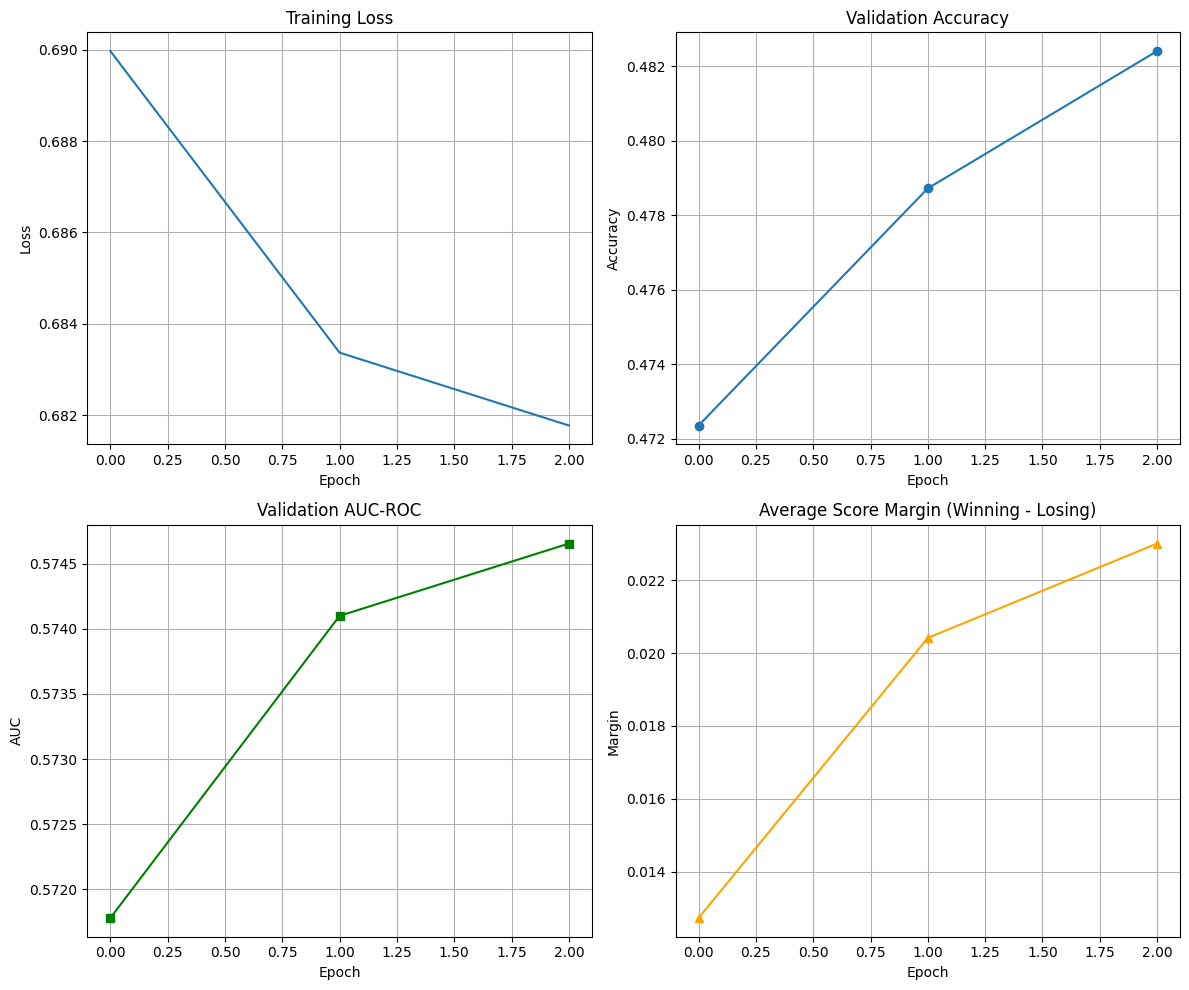

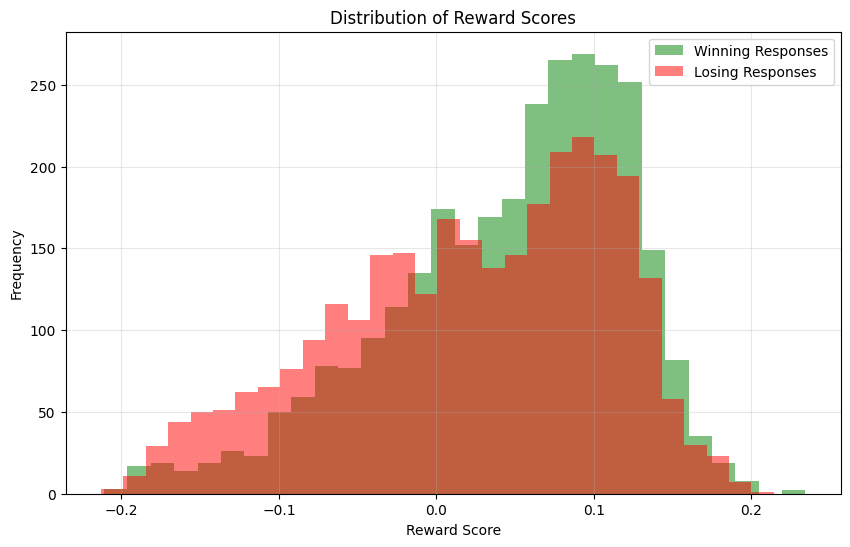


MODEL COMPARISON: Before vs After Training

Sample 1:
Prompt: How do I detail a car?
Good Response: Detailing a car involves a thorough cleaning inside and out, as well as polishing and waxing to prot...
Bad Response: Detailing a car involves washing the exterior and interior of the car, as well as polishing and waxi...

Model Before Training:
  Good Response Score: -0.058
  Bad Response Score: -0.058
  Margin: -0.000

Model After Training:
  Good Response Score: 0.103
  Bad Response Score: 0.038
  Margin: 0.064
  ✓ Improvement: +0.065
------------------------------------------------------------

Sample 2:
Prompt: Who created the Superman cartoon character?
Good Response: Superman, the iconic comic book superhero, was created by writer Jerry Siegel and artist Joe Shuster...
Bad Response: The Superman cartoon character was created by Jerry Siegel and Joe Shuster in 1938....

Model Before Training:
  Good Response Score: -0.049
  Bad Response Score: -0.028
  Margin: -0.021

Model After 

In [30]:
from tqdm import tqdm
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model_name = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model_untrained = RewardModel(model_name).to(device)
    model = RewardModel(model_name).to(device)

    train_dataset = PreferenceDataset(tokenizer, final_dataset)
    trained_model, evaluator = train_with_evaluation(
        model=model,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        tokenizer=tokenizer,
        device=device,
        num_epochs=5,
        batch_size=2, 
        learning_rate=1e-5
    )
    
    print("\n" + "="*60)
    print("Generating Evaluation Plots")
    print("="*60)
    
    evaluator.plot_training_progress()
    evaluator.plot_score_distribution(test_data)
    
    demonstrate_model_improvements(
        model_before=model_untrained,
        model_after=trained_model,
        test_samples=test_data,
        tokenizer=tokenizer,
        device=device
    )
    
    print("\n" + "="*60)
    print("Final Evaluation Summary")
    print("="*60)
    
    final_metrics = evaluator.evaluate_on_pairs(test_data)
    print(f"Final Model Performance:")
    print(f"  - Accuracy: {final_metrics['accuracy']:.4f}")
    print(f"  - AUC-ROC: {final_metrics['auc']:.4f}")
    print(f"  - Average Margin: {final_metrics['avg_margin']:.4f}")
    print(f"  - Consistency: {final_metrics['consistency']:.4f}")
    
    torch.save(trained_model.state_dict(), 'reward_model_trained.pt')
    print("\n✓ Model saved as 'reward_model_trained.pt'")


    # with open('training_history.json', 'w') as f:
    #     json.dump(evaluator.history, f, indent=2)
    # print("Training history saved as 'training_history.json'")


if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    
    model_untrained = RewardModel("distilbert-base-uncased").to(device)
    model = RewardModel("distilbert-base-uncased").to(device)
    train_dataset = PreferenceDataset(tokenizer, final_dataset)    
    trained_model, evaluator = train_with_evaluation(
        model=model,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        tokenizer=tokenizer,
        device=device,
        num_epochs=3,
        batch_size=20,
        learning_rate=1e-5
    )
    
    evaluator.plot_training_progress()
    evaluator.plot_score_distribution(test_dataset)
    
    demonstrate_model_improvements(
        model_before=model_untrained,
        model_after=trained_model,
        test_samples=test_dataset[:10],
        tokenizer=tokenizer,
        device=device
    )
    
    print("\nTraining and evaluation completed successfully!")